In [1]:
%matplotlib inline

This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

The core model is an GRU.

# todos:
* dropout
* L1/L2 regularization
* validation and AUC

In [2]:
from __future__ import print_function, division
from io import open
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [3]:
use_cuda

True

In [4]:
# prepare data: load the input file containing list of list of list, and corresponding label file
# and output the merged list of pairs
import sys, random
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle

# set random seed
random.seed( 3 )

seqFile = 'data/cerner/hospital_data/h143.visits'
labelFile = 'data/cerner/hospital_data/h143.labels'
set_x = pickle.load(open(seqFile, 'rb'), encoding='bytes')
set_y = pickle.load(open(labelFile, 'rb'),encoding='bytes')

labeled_ehr_seq_list = [(set_y[i],set_x[i]) for i in range(len(set_x))] # merge the two lists

In [6]:
labeled_ehr_seq_list[10]
# [float(v) for v in c]

(0,
 [[752, 267, 84, 85],
  [922, 267, 84, 85],
  [320, 267, 84, 85],
  [119, 361, 129, 381, 267, 84, 85],
  [816, 267, 84, 85],
  [320, 267, 84, 85],
  [320, 267, 84, 85],
  [119, 129, 381, 267, 84, 85],
  [119, 127, 129, 381, 267, 84, 85],
  [2334, 267, 84, 85],
  [320, 267, 84, 85],
  [3255, 119, 320, 129, 381, 267, 84, 85],
  [964, 267, 84, 85],
  [1266, 267, 84, 85],
  [320, 267, 84, 85],
  [964, 243, 267, 84, 85],
  [964, 243, 267, 84, 85],
  [3566, 381, 267, 84, 85],
  [964, 267, 84, 85],
  [320, 267, 84, 85],
  [984, 129, 381, 267, 84, 85],
  [964, 267, 84, 85],
  [964, 243, 267, 84, 85],
  [964, 267, 84, 85],
  [964, 267, 84, 85]])

In [53]:
class EHR_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EHR_RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(self.hidden_size,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(-1, 1, self.hidden_size)
        embedded = torch.sum(embedded, dim=0).view(1,1,-1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
            
        output = self.sigmoid(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [13]:
# training one sample
def train(label_tensor, ehr_seq_tensor, criterion, optimizer):
    hidden = ehr_rnn.initHidden()

    ehr_rnn.zero_grad()

    for i in range(len(ehr_seq_tensor)):
        output, hidden = ehr_rnn(ehr_seq_tensor[i], hidden)

    loss = criterion(output, label_tensor)
    loss.backward()

    optimizer.step()
   
    return output, loss.data[0]


In [57]:
def variableFromEHRSeq(ehr_seq):
    # ehr_seq is a list of list
    result = []
    if use_cuda:
        for i in range(len(ehr_seq)):
            result.append( Variable(torch.LongTensor([int(v) for v in ehr_seq[i]])).cuda() )
    # if use_cuda:
    #     return result.cuda()
    else:
        for i in range(len(ehr_seq)):
            result.append( Variable(torch.LongTensor([int(v) for v in ehr_seq[i]])) )

    return result

In [63]:
# training all samples in random order
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

input_size = 20000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



In [64]:
start = time.time()
ehr_rnn = EHR_RNN(input_size, hidden_size = 128)
if use_cuda:
    ehr_rnn = ehr_rnn.cuda()
learning_rate = 0.001
optimizer = optim.SGD(ehr_rnn.parameters(), lr=learning_rate)

for iter in range(1, n_iters + 1):
    label, ehr_seq = random.choice(labeled_ehr_seq_list)
    label_tensor = Variable(torch.FloatTensor([[float(label)]]))
    if use_cuda:
        label_tensor = label_tensor.cuda() 
    ehr_seq_tensor = variableFromEHRSeq(ehr_seq)
    
    output, loss = train(label_tensor, ehr_seq_tensor, criterion = nn.BCELoss(), optimizer = optimizer)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        print('%d %d%% (%s) %.4f ' % (iter, iter / n_iters * 100, timeSince(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (1m 51s) 0.5080 
10000 10% (3m 35s) 0.1839 
15000 15% (5m 19s) 0.0353 
20000 20% (7m 24s) 0.1434 
25000 25% (9m 42s) 2.7767 
30000 30% (12m 3s) 0.0635 
35000 35% (14m 22s) 0.3095 
40000 40% (16m 39s) 0.1712 
45000 45% (18m 46s) 0.1348 
50000 50% (20m 57s) 3.2124 
55000 55% (23m 19s) 0.1367 
60000 60% (25m 44s) 0.0407 
65000 65% (28m 3s) 0.0849 
70000 70% (30m 28s) 0.0532 
75000 75% (32m 30s) 0.0138 
80000 80% (34m 40s) 0.1071 
85000 85% (37m 2s) 0.3427 
90000 90% (38m 57s) 0.2190 
95000 95% (41m 13s) 0.0731 
100000 100% (43m 15s) 0.0948 


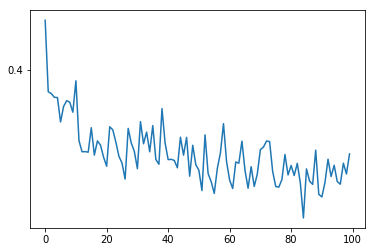

In [68]:
# plotting and diagnose
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
showPlot(all_losses)

In [ ]:
# validation/test


In [69]:
all_losses

[0.45036185389384625,
 0.3775859723575413,
 0.37562936810404063,
 0.37186373338475825,
 0.37163539075478913,
 0.34679124680161477,
 0.3626916835568845,
 0.36841993424110114,
 0.3669160178825259,
 0.3567359281945974,
 0.3886930065229535,
 0.32770080245751887,
 0.3164230008115992,
 0.31659249229449776,
 0.3160534981070086,
 0.340928599646315,
 0.31306948912795635,
 0.32751105540990827,
 0.323151018537581,
 0.31089705776702614,
 0.30170459143724293,
 0.3418931403569877,
 0.3387779448628426,
 0.32615592231974005,
 0.311701596298255,
 0.3049053551144898,
 0.2886118961106986,
 0.3402360961185768,
 0.32545276371855286,
 0.3168499764781445,
 0.29920316889882087,
 0.3471019284585491,
 0.3246009302129969,
 0.3364823093246669,
 0.3163939027907327,
 0.34309222260443495,
 0.30858820424694566,
 0.3037130907261744,
 0.3603678338378668,
 0.32562145951017735,
 0.30843497765483335,
 0.30875648852437737,
 0.30761466614482924,
 0.30013829468004405,
 0.3313037310056388,
 0.31298728902917355,
 0.33107836460